# Visualisation of the rdii in borsuk

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os.path
import statsmodels.api as sm
import statistics
import http.client
import json
import urllib.request
import requests
import random
from urllib import error
import configparser 
import datetime
import re
import time

### Accessing the token
Pobranie danych dla kanału 

In [2]:
config = configparser.ConfigParser()
config.read("config.txt")

['config.txt']

In [3]:
http_client = config.get("configuration","http_client")
conn = http.client.HTTPConnection(http_client)
headers = {'Content-type': 'application/json'}

In [4]:
Username = config.get("configuration","user")
Password = config.get("configuration","password")

In [5]:
body = { 'Username': Username, 'Password': Password}
conn.request("POST","/auth/authenticate", json.dumps(body),headers)
response = conn.getresponse()
x = response.read().decode()
token = json.loads(x)['token']

### Loading the data set

In [6]:
url_rain = config.get("configuration", "url_rain") + token
url_flow = config.get("configuration", "url_flow") + token

In [7]:
df_rain = pd.read_csv(url_rain, parse_dates=['time'])
df_flow = pd.read_csv(url_flow, parse_dates=['time'])

In [8]:
df_flow.head()

,time,value
0,2011-07-12 12:15:00,2.267409
1,2011-07-12 12:30:00,2.314310
2,2011-07-12 12:45:00,2.259863
3,2011-07-12 13:00:00,2.153435
4,2011-07-12 13:15:00,2.085203


### Creating dataset where missing rows are given -1

In [9]:
df_rain = df_rain.set_index('time')
df_rain = df_rain.resample('300S').asfreq()

In [10]:
df_rain = df_rain.reset_index()

In [11]:
df_flow = df_flow.set_index('time')
df_flow = df_flow.resample('900S').asfreq()

In [12]:
df_flow = df_flow.reset_index()

In [13]:
df_rain = df_rain.fillna(-1)
df_flow = df_flow.fillna(-1)

### Taking the fragment of the data to the model

In [14]:
split_rain = df_rain[(df_rain['time'] > '2012-09-16 00:00:00')]
split_rain = split_rain[(split_rain['time'] < '2016-4-9 00:00:00')]
split_flow = df_flow[(df_flow['time'] > '2012-09-16 00:00:00')]
split_flow = split_flow[(split_flow['time'] < '2016-4-9 00:00:00')]

In [15]:
split_flow.head()

,time,value
41424,2012-09-16 00:15:00,1.018260
41425,2012-09-16 00:30:00,0.969223
41426,2012-09-16 00:45:00,0.983287
41427,2012-09-16 01:00:00,0.912357
41428,2012-09-16 01:15:00,0.867315


### Creating the json variable

In [16]:
rdii = {
  "flow": {
    "start-date": "2012-09-16",
    "resolution": "PT15M",
    "values":  list(split_flow['value'])
  },
  "rainfall": {
    "start-date": "2012-09-16",
    "resolution": "PT5M",
    "values":  list(split_rain['value'])
  },
    "dryDayWindow": "P2D",
    "minSessionWindow": "PT12H",
    "maxSessionWindow": "PT12H"
}

### POST to borsuk-rdii alicja-test-model

In [17]:
#{"type":"rdiis-v0", "id": "model-id"}

In [18]:
rdii_url = config.get("configuration", "rdii_url")
body={"type":"rdiis-v0","id": "rdii_test"}
response = requests.post(rdii_url, json=body)
print(response.status_code)
print(response.content)

409
b'Error: Model with this id already exist.'


### GET to borsuk-rdii alicja-test-model

In [19]:
rdii_model = config.get("configuration", "rdii_model")
r = requests.get(rdii_model)
last_build = json.loads(r.content)['build']
print(last_build)

3


### POST to borsuk json data fragment

In [20]:
body=rdii
url_fit = config.get("configuration", "rdii_fit")
response = requests.post(url_fit, json=body)
print(response.status_code)
print(response.content)

200
b'OK'


### GET rdii
The change of status informs that the post is finished

In [21]:
print("Primary status: ",last_build)
start_time = time.time()

while True:
    r = requests.get(rdii_model)
    new_build = json.loads(r.content)['build']
    if new_build > last_build:
        print("Status after post: ",new_build)
        break

print("--- %s seconds ---" % (time.time() - start_time))

Primary status:  3
Status after post:  4
--- 37.842416524887085 seconds ---


### Get rdii with dryDayWindow: P2D

In [22]:
rdii_session = config.get("configuration", "rdii_session")
r = requests.get(rdii_session)
session = json.loads(r.content)

### Get rdii with exemplary id

In [23]:
rdii_id = config.get("configuration", "rdii_id")
rdii_id = rdii_id + '/2'
r = requests.get(rdii_id)
b = json.loads(r.content)

### Create variables from json

In [24]:
st_date = b['start-date']
en_date = b['end-date']
dwp = b['dwp']
flow = b['flow']
rain = b['rainfall']
rdii_v = b['rdii']
print(st_date, en_date)

2012-10-15T04:15 2012-10-16T06:00


In [25]:
dt = datetime.datetime(2012, 10, 15,4,15)
end = datetime.datetime(2012, 10, 16, 6,15)
step = datetime.timedelta(seconds=900)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
    dt += step

In [26]:
b_time = pd.DataFrame(result)
b_dwp = pd.DataFrame(dwp)
b_flow = pd.DataFrame(flow)
b_rain = pd.DataFrame(rain)
b_rdii = pd.DataFrame(rdii_v)

In [27]:
b_time[0] = pd.to_datetime(b_time[0])

### Rolling window on borsuk dwp

In [28]:
rdii_roll = b_rdii.rolling(4).mean()
rdii_roll = rdii_roll.fillna(rdii_roll.mean())

# Comparing results with rdii from flowworks.http

### Get data from flowworks

In [29]:
flowworks = config.get("configuration", "flowworks")
r = requests.get(flowworks)
flow_data = json.loads(r.content)

### Create variables for plot

In [30]:
flow_datetime = flow_data['index']
flow_dwp = flow_data['dwp']
flow_flow = flow_data['flow']
flow_rain = flow_data['rainfall']
flow_rdii = flow_data['rdii1']

In [31]:
flow = pd.DataFrame(flow_datetime)

In [32]:
flow = flow.replace({'T':' '}, regex=True)
flow = flow.replace({'Z':' '}, regex=True)

In [35]:
flow['dwp'] = flow_dwp
flow['flow'] = flow_flow
flow['rdii'] = flow_rdii
flow.columns = ['time', 'dwp','flow','rdii']

In [36]:
flow['time'] = pd.to_datetime(flow['time'])

In [37]:
rain = pd.DataFrame(flow_rain)

In [38]:
flow = pd.concat([flow,rain], ignore_index=True, axis=1)
flow.columns = ['time', 'dwp','flow','rdii','rain']
flow.head()

,time,dwp,flow,rdii,rain
0,2012-10-15 00:00:00,1.028379,1.016080,0.050243,0.0
1,2012-10-15 00:15:00,0.909938,1.001293,0.029934,0.0
2,2012-10-15 00:30:00,0.919655,1.012317,0.034547,0.0
3,2012-10-15 00:45:00,0.949169,0.989730,0.053070,0.0
4,2012-10-15 01:00:00,0.880648,0.902340,0.061568,0.0


In [39]:
flow.to_csv('results.csv', index=False, header=True)

### Plotting rdii from flowworks.http

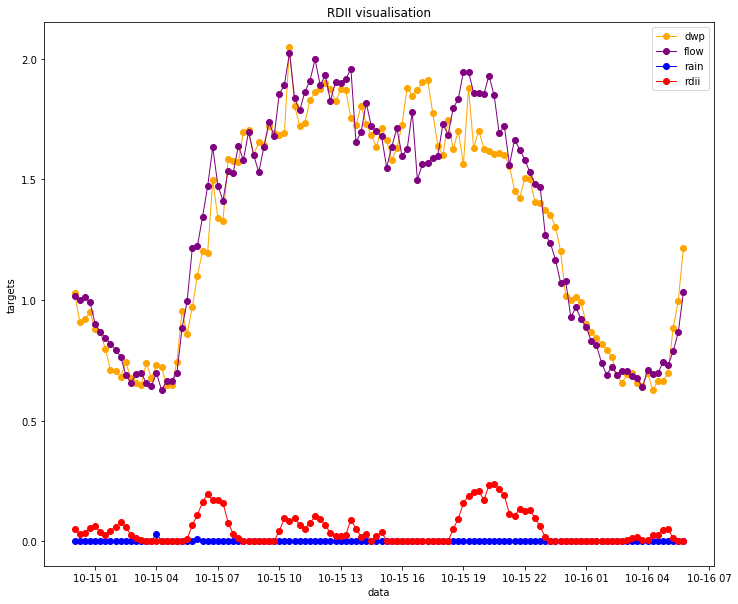

In [40]:
plt.figure(figsize=(12, 10))
plt.plot(flow['time'], flow['dwp'], color="orange",marker="o",label="dwp", linewidth=1)
plt.plot(flow['time'], flow['flow'], c='purple',marker="o", label="flow",linewidth=1)
plt.plot(flow['time'], flow['rain'], c='blue',marker="o", label="rain",linewidth=1)
plt.plot(flow['time'], flow['rdii'], c='red',marker="o", label="rdii",linewidth=1)

plt.xlabel("data")
plt.ylabel("targets")
plt.title("RDII visualisation")
plt.legend()
plt.show()

### Plotting rdii from borsuk

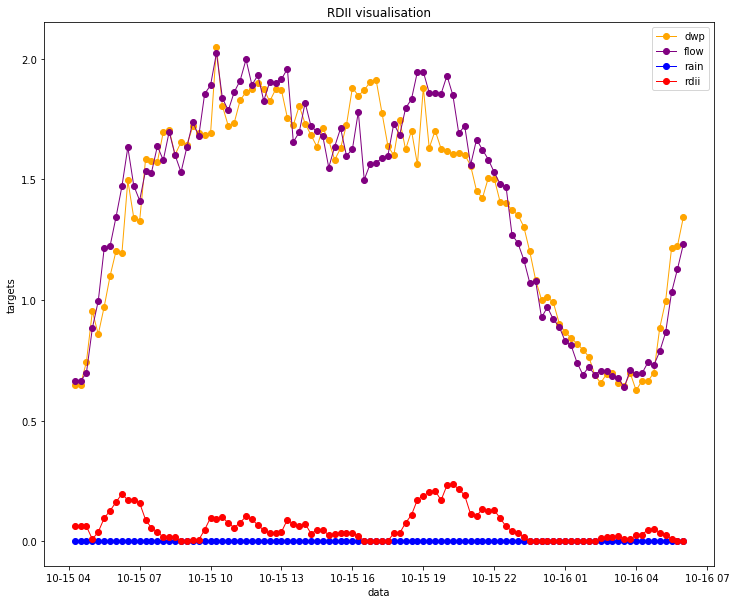

In [41]:
plt.figure(figsize=(12, 10))
plt.plot(b_time, b_dwp, color="orange",marker="o",label="dwp", linewidth=1)
plt.plot(b_time, b_flow, c='purple',marker="o", label="flow",linewidth=1)
plt.plot(b_time, b_rain, c='blue',marker="o", label="rain",linewidth=1)
plt.plot(b_time, rdii_roll, c='red',marker="o", label="rdii",linewidth=1)

plt.xlabel("data")
plt.ylabel("targets")
plt.title("RDII visualisation")
plt.legend()
plt.show()